# Clone repository and install requirements

In [1]:
# !git clone https://github.com/kad99kev/FGTD.git

fatal: destination path 'FGTD' already exists and is not an empty directory.


In [2]:
# import sys
# sys.path.append('/content/FGTD/scripts')

In [2]:
!pip install -r requirements.txt

  Using cached wandb-0.10.27-py2.py3-none-any.whl.metadata (6.6 kB)
Using cached wandb-0.10.27-py2.py3-none-any.whl (2.1 MB)
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.6
    Uninstalling wandb-0.16.6:
      Successfully uninstalled wandb-0.16.6



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install --upgrade wandb

  Using cached wandb-0.16.6-py3-none-any.whl.metadata (10 kB)
Using cached wandb-0.16.6-py3-none-any.whl (2.2 MB)
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.27
    Uninstalling wandb-0.10.27:
      Successfully uninstalled wandb-0.10.27



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import wandb

In [5]:
import wandb
wandb.init(project="text-to-face", name="n-dcgan")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\rache\.netrc


# Import dependencies

In [6]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [8]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [ ]:
# # File Constants
# ZIP_PATH = "."
# # OUTPUT_DIR = "."

In [ ]:
# extract_zip(ZIP_PATH, OUTPUT_DIR)

In [58]:
OUTPUT_DIR = "."

# Data Loading

## Initialize Constants

In [59]:
@dataclass
class Config:
  epochs: int = 20
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [61]:
sentence_encoder = SentenceEncoder(cfg.device)

Some weights of the model checkpoint at C:\Users\rache/.cache\torch\sentence_transformers\sbert.net_models_bert-base-nli-mean-tokens\0_BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Initialize Helpers (for images)

In [62]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Creating Custom Dataset Class

In [63]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        # img_name = img_name.replace('\\', '/')
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [64]:
dataset = ImageNTextDataset(OUTPUT_DIR, 'text_5_descr_celeba.csv', transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

## Creating subset of dataset

In [65]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'celeba/list_attr_celeba.csv',
    image_location='celeba/img_align_celeba/img_align_celeba/'.replace("\\",'/'),
    text_desc_location='text_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'High_Cheekbones', 'Pointy_Nose', 'Gray_Hair', 'Black_Hair', 'Heavy_Makeup', 'Wavy_Hair', 'Wearing_Lipstick', 'Mouth_Slightly_Open', 'Goatee', 'Oval_Face', 'Rosy_Cheeks', 'Wearing_Necktie', 'Straight_Hair', 'Smiling', 'Arched_Eyebrows', 'Bushy_Eyebrows', 'Wearing_Earrings', 'Sideburns', 'Bald', 'Male', 'Chubby', 'Wearing_Hat', 'Blond_Hair', 'Young', 'Big_Nose', 'Mustache', 'Receding_Hairline', 'Wearing_Necklace', 'Pale_Skin', 'Big_Lips', 'Double_Chin', '5_o_Clock_Shadow', 'Attractive', 'Narrow_Eyes', 'Eyeglasses', 'Brown_Hair'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


In [56]:
# weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
#     'celeba/list_attr_celeba.csv',
#     custom_dataset=dataset,
#     subset_size=cfg.subset_size,
#     batch_size=cfg.batch_size
# )

Length of random indices: 20000
Classes present:  {'High_Cheekbones', 'Pointy_Nose', 'Gray_Hair', 'Black_Hair', 'Heavy_Makeup', 'Wavy_Hair', 'Wearing_Lipstick', 'Mouth_Slightly_Open', 'Goatee', 'Oval_Face', 'Rosy_Cheeks', 'Wearing_Necktie', 'Straight_Hair', 'Smiling', 'Arched_Eyebrows', 'Bushy_Eyebrows', 'Wearing_Earrings', 'Sideburns', 'Bald', 'Male', 'Chubby', 'Wearing_Hat', 'Blond_Hair', 'Young', 'Big_Nose', 'Mustache', 'Receding_Hairline', 'Wearing_Necklace', 'Pale_Skin', 'Big_Lips', 'Double_Chin', '5_o_Clock_Shadow', 'Attractive', 'Narrow_Eyes', 'Eyeglasses', 'Brown_Hair'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


## Testing Dataloader output

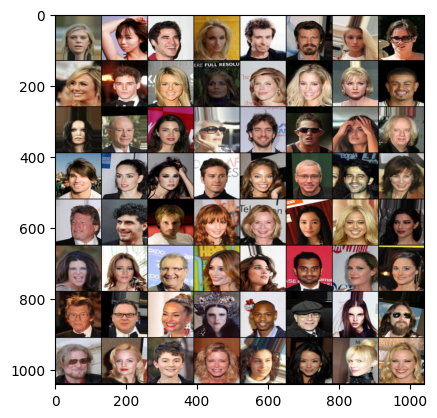

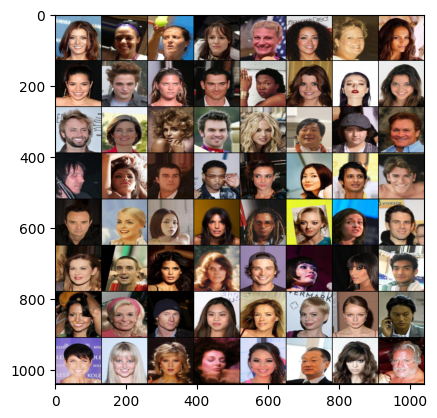

['The lady has an oval face. She has blond and straight hair. She has a slightly open mouth. The lady is young. She is wearing earrings and lipstick.', 'Her hair is straight. She has big lips. The female is attractive and young. She is wearing lipstick.', "The male has high cheekbones. He has a 5 o' clock shadow. He has black hair. He has a big nose, bushy eyebrows, a slightly open mouth and narrow eyes. The male is smiling.", 'The lady has high cheekbones. Her hair is blond. She has arched eyebrows, big lips and a pointy nose. The lady seems attractive and young.', "The gentleman has high cheekbones. He wears a 5 o' clock shadow. His hair is brown and wavy. He has a big nose, bushy eyebrows and a pointy nose. The man looks young. He is wearing a necklace.", 'The male has pretty high cheekbones. He has a goatee. His hair is brown. The male seems young.', 'She has blond and straight hair. She has big lips and a pointy nose. The female is young.', 'She has big lips and a slightly open mo

In [66]:
images, labels, wrong_images = weighted_dataiter.__next__()
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

# Initialize Weights

In [67]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [68]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [69]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

## Test output shape of Generator

torch.Size([64, 3, 128, 128])


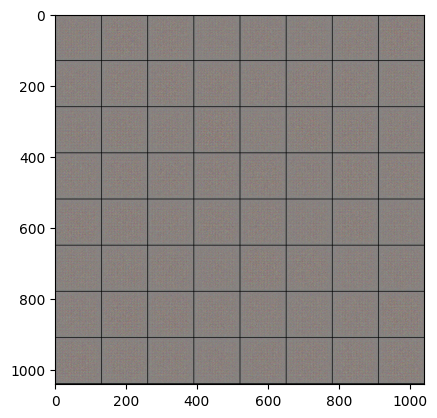

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [70]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

## Create Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [71]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)

        projected_embed = self.projector(text_embeddings)

        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)

        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [72]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

## Test output shape of Discriminator

In [73]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([64, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

# Specifying Loss Functions

In [74]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

# Plotting output after each epoch

This is just to generate a batch of text embeddings to be used to plot

In [76]:
plt_images, plt_labels, plt_wrong = weighted_dataiter.__next__()
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

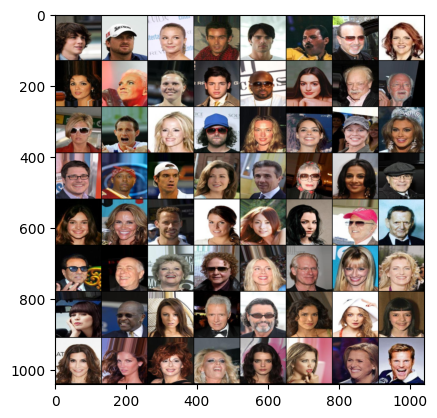

['He has wavy hair. He has a slightly open mouth and a pointy nose. The gentleman is smiling and is young.', 'He has sideburns. He has a slightly open mouth. The male seems young. He is wearing a hat.', 'The woman has high cheekbones and an oval face. Her hair is blond, straight and receding. She seems attractive, young, is smiling, has rosy cheeks and heavy makeup. She is wearing earrings and lipstick.', "He grows a 5 o' clock shadow and has sideburns. He has black and straight hair. He has arched eyebrows, bushy eyebrows, a slightly open mouth and a pointy nose. The man is young.", "He sports a 5 o' clock shadow and sports a goatee. His hair is black and straight. He has bushy eyebrows. The gentleman seems attractive and young.", 'He wears a mustache. His hair is black and straight. He has bushy eyebrows, a slightly open mouth and a pointy nose. The man looks young.', "The male is chubby and has a double chin. He has a 5 o' clock shadow, grows a goatee and sports a mustache. His hair

In [77]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [78]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [79]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training

0it [00:00, ?it/s]

Epoch:  1 / 20
Discriminator Loss: 3.793, Generator Loss: 31.167


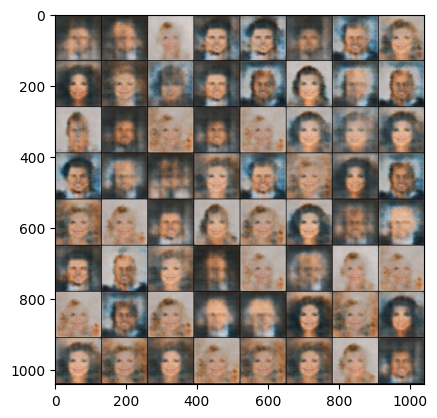

Epoch:  2 / 20
Discriminator Loss: 1.856, Generator Loss: 27.654


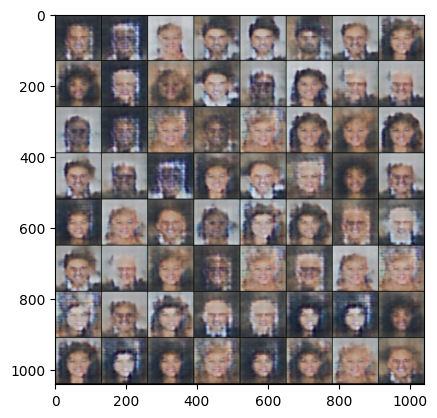

Epoch:  3 / 20
Discriminator Loss: 1.786, Generator Loss: 27.705


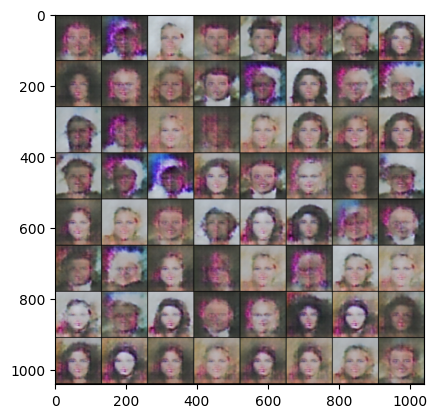

Epoch:  4 / 20
Discriminator Loss: 1.785, Generator Loss: 27.517


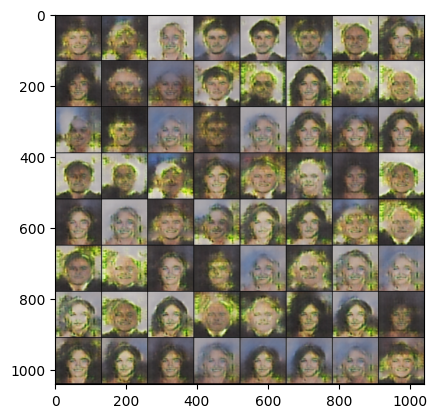

Epoch:  5 / 20
Discriminator Loss: 1.757, Generator Loss: 27.553


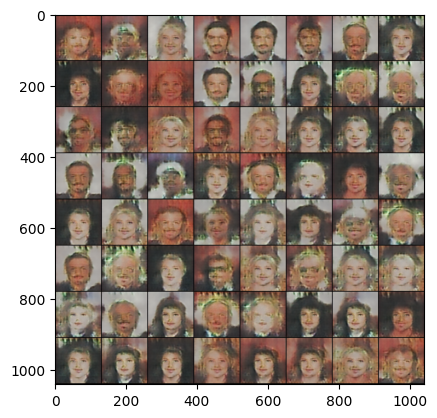

Epoch:  6 / 20
Discriminator Loss: 1.747, Generator Loss: 27.464


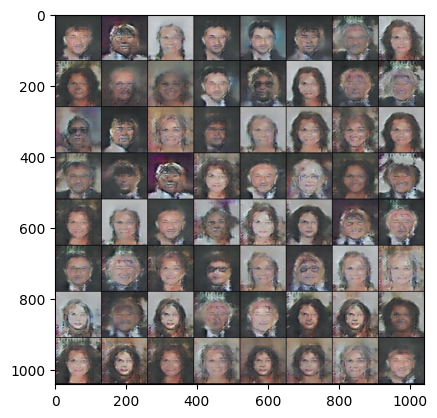

Epoch:  7 / 20
Discriminator Loss: 1.735, Generator Loss: 27.415


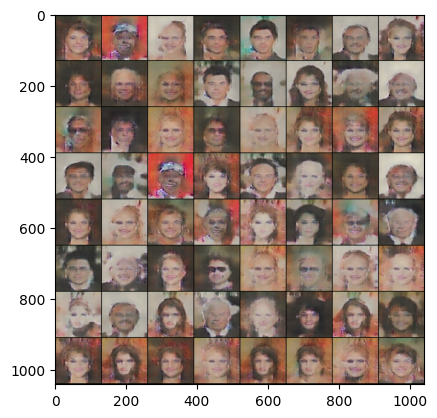

Epoch:  8 / 20
Discriminator Loss: 1.727, Generator Loss: 27.320


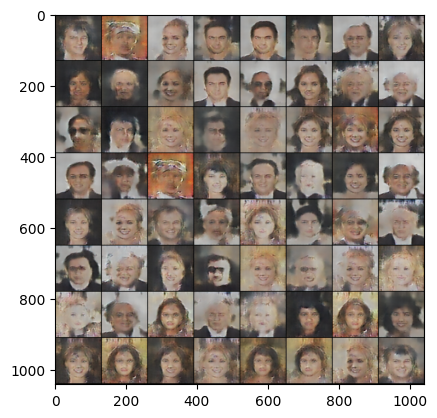

Epoch:  9 / 20
Discriminator Loss: 1.715, Generator Loss: 27.354


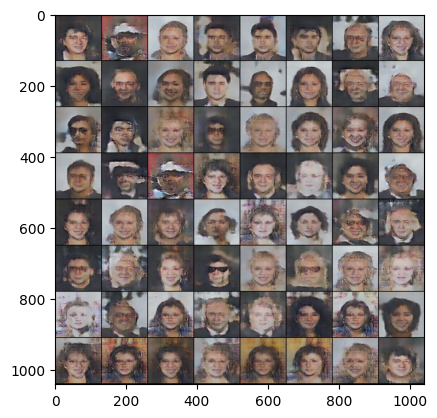

Epoch:  10 / 20
Discriminator Loss: 1.706, Generator Loss: 27.132


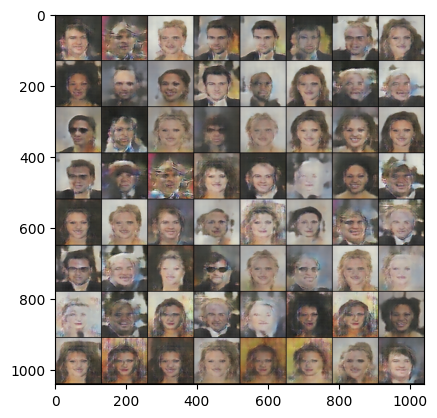

Epoch:  11 / 20
Discriminator Loss: 1.698, Generator Loss: 27.194


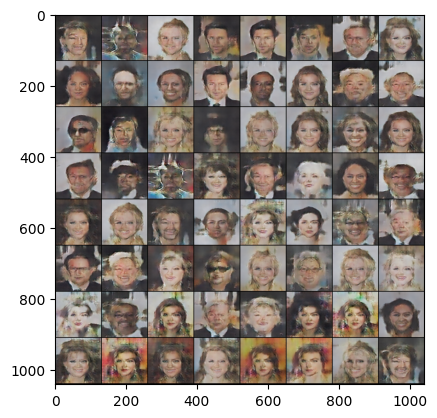

Epoch:  12 / 20
Discriminator Loss: 1.672, Generator Loss: 27.179


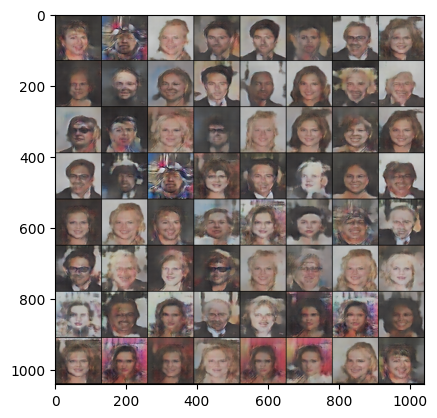

Epoch:  13 / 20
Discriminator Loss: 1.669, Generator Loss: 27.109


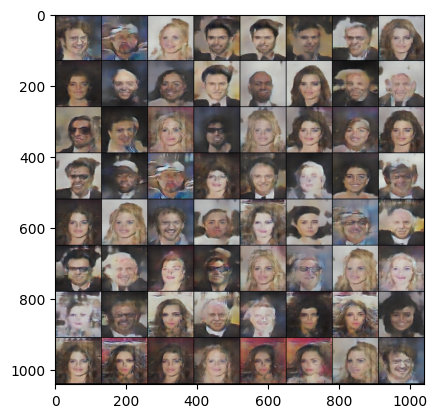

Epoch:  14 / 20
Discriminator Loss: 1.659, Generator Loss: 26.991


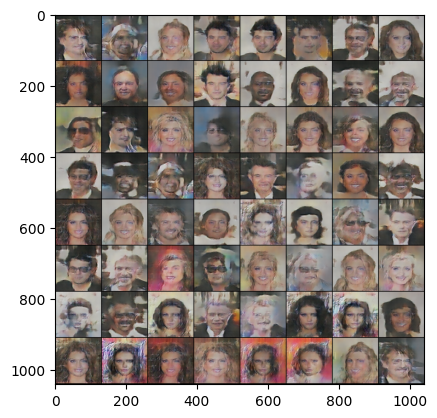

Epoch:  15 / 20
Discriminator Loss: 1.672, Generator Loss: 26.993


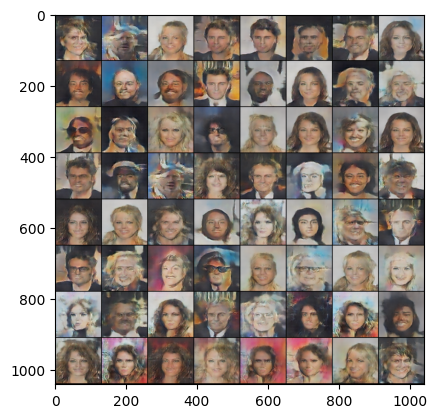

Epoch:  16 / 20
Discriminator Loss: 1.656, Generator Loss: 26.873


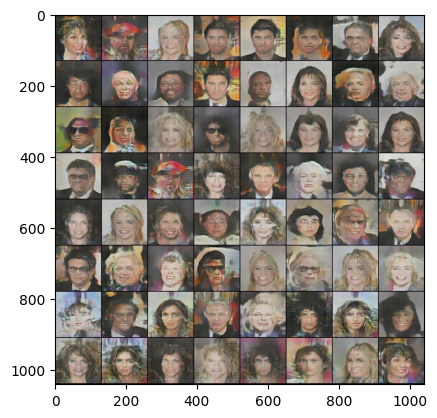

Epoch:  17 / 20
Discriminator Loss: 1.633, Generator Loss: 26.816


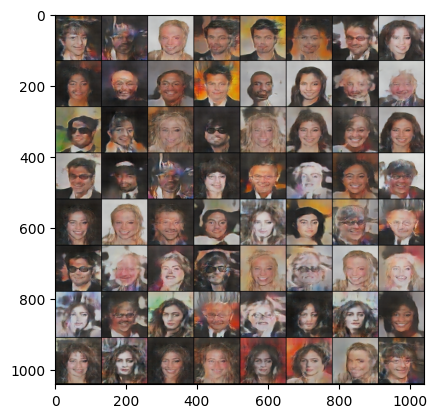

Epoch:  18 / 20
Discriminator Loss: 1.625, Generator Loss: 26.790


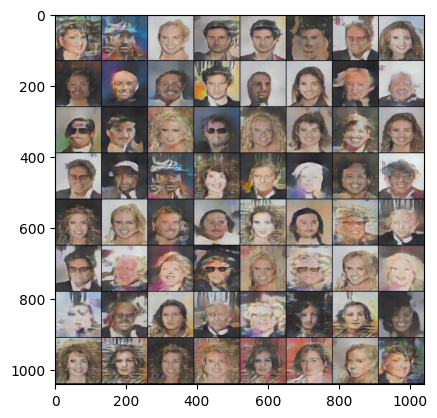

Epoch:  19 / 20
Discriminator Loss: 1.598, Generator Loss: 26.794


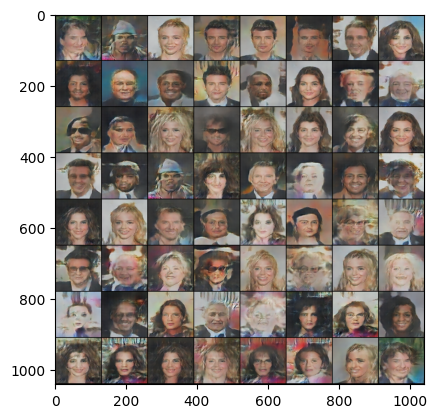

Epoch:  20 / 20
Discriminator Loss: 1.594, Generator Loss: 26.764


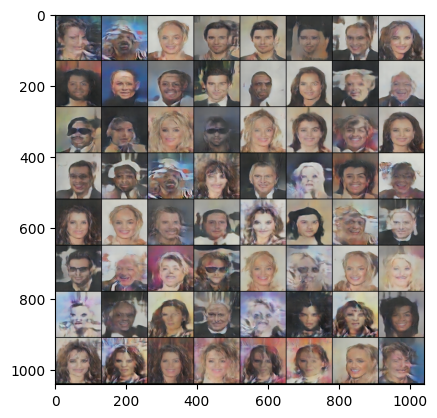

True

In [80]:
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda()

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))

    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_loss)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_loss))}, step=epoch+1)

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

# Output

In [86]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The male has high cheekbones and an oval face. His hair is blond and straight. He has bushy eyebrows, a slightly open mouth and a pointy nose. The gentleman is attractive, young, is smiling. He is wearing a necktie'])

In [87]:
test_noise.shape, test_embeddings.shape

(torch.Size([1, 100]), torch.Size([1, 768]))

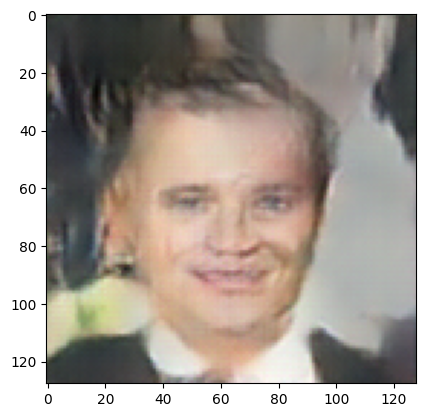

In [88]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [103]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The woman has pretty high cheekbones and an oval face. Her hair is black and wavy. She has arched eyebrows.  She is wearing earrings, lipstick and a necklace.'])

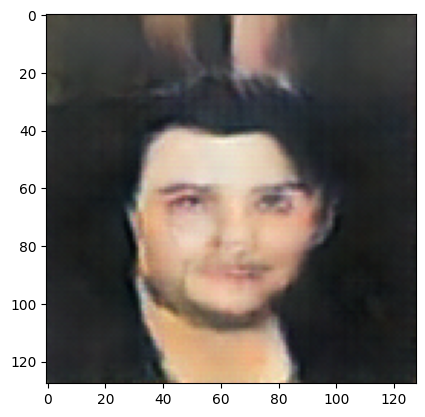

In [104]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))